# Model for predicting flight delays 

This notebook will serve as a single notebook to run all the desired models on a given dataset

# 1. Initial Setup

In [0]:
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import types
SEED = 7

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

In [0]:
# Enable for pretty viewing of tables
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [0]:
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
project_path = userhome + "/FinalProject/"
display(dbutils.fs.ls(project_path))

dbfs:/user/chitra.agastya@ischool.berkeley.edu

path,name,size
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/Chitra_feature_data/,Chitra_feature_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airline_singleday.parquet/,airline_singleday.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_features_ext.parquet/,airlines_3m_features_ext.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_full_features.parquet/,airlines_3m_full_features.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_weather_data/,airlines_weather_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport-timezones.csv,airport-timezones.csv,439779
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges/,airport_edges/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_1_year/,airport_edges_1_year/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_3_month/,airport_edges_3_month/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_4_year/,airport_edges_4_year/,0


In [0]:
# Load training, validation and test data directories
train_dir = "train.parquet"
dev_dir = "dev.parquet"
test_dir = "test.parquet"
mode = 'full'
outcome = 'is_delayed'
run = 'full'

save_path = project_path + "Chitra_feature_data"
loadPipelineFromFile = False
savePipeline = False

print(f'Project Path: {project_path} mode:{mode}')

Project Path: dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/ mode:full

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer, StandardScaler, FeatureHasher, SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Load the training data
def loadData(dirName, viewName):
  data = spark.read.option("header", "true").parquet(f'{project_path}{dirName}/*.parquet')
  data.createOrReplaceTempView(viewName)
  return data

def preProcessData(dff, outcome = 'is_delayed'):
  
  # Take care of unknown weather values
  # Convert pressure 9999 to null
  for col in [x for x in dff.columns if x.endswith('_pressure')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 9999, None).otherwise(f.col(col)))
    
  # Convert ceiling 99999 to None
  for col in [x for x in dff.columns if x.endswith('_ceiling')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 99999, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_speed')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999.9, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_angle')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999, None).otherwise(f.col(col)))
  
  # Convert visibility and ceiling to integer values
  for col in [x for x in dff.columns if x.endswith('_visibility') or x.endswith('_ceiling')]:
    dff = dff.withColumn(col, dff[col].cast(IntegerType()))

  # Convert temperature and dewpoint to Kelvin by adding 273
  for col in [x for x in dff.columns if x.endswith('_temperature') or x.endswith('_dewpoint')]:
    dff = dff.withColumn(col, dff[col] + 273)
    
  dff = dff.withColumn('time_blk', ((dff['dep_blk'].cast(IntegerType()) + 2) / 8).cast(IntegerType()))
  # cast the equipment_delayed to numeric int
  dff = dff.withColumn('equipment_delayed', dff['equipment_delayed'].cast(IntegerType()))
  
  # create the outcome column
  dff = dff.withColumn(outcome, f.when(f.col('dep_del15') == 1, 1)
                                .otherwise(0)
                      )
  return dff

def partitionData(dff, start_date, end_date):
    return dff.filter(f"make_date(year, month, day_of_month) between '{start_date}' and '{end_date}'")

# a more parallel attempt
def createStages2(dff, outcome, run = 'basic'):
  stages = []
  
  #Preprocess the Data
  dff = preProcessData(dff).cache()
  
  # Get the categorical columns
  categoricalColumnsNoAirports = ['month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  # add equipement_delayed for non-basic runs
  if run != 'basic':
    categoricalColumnsNoAirports += ['equipment_delayed']
  # and our full set includes origin and destination for string indexing 
  filterColumns = ['origin', 'destination'] 
  categoricalColumns = filterColumns + categoricalColumnsNoAirports
  
  
  # index their strings. sadly, no parallel method for that
  stringIndexers = [StringIndexer(inputCol = col, outputCol = col + 'Index').setHandleInvalid("keep") for col in categoricalColumns]
  stages += stringIndexers
          
  # one-hot encode the categorical columns
  encoder = OneHotEncoder(inputCols=[col + 'Index' for col in categoricalColumnsNoAirports], \
                          outputCols=[col + "classVec" for col in categoricalColumnsNoAirports], \
                          handleInvalid='keep')
  stages += [encoder]
  
  # add the outcome label
  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  # [x for x in dff.columns if x.startswith('avg_')] + \
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_'))]
  
  # impute, vectorize and scale numeric columns
  imputedCols = [col+"_Imputed" for col in numericCols]
  imputer = Imputer(inputCols=numericCols, outputCols=imputedCols, strategy='mean')
  
  # from our runs, it looks like the parallel imputer might not have a deterministic output column order
  # make sure the resulting columns are in a defined order
  cols = ['label', 'originIndex', 'destinationIndex'] + [c+"classVec" for c in categoricalColumnsNoAirports] + imputedCols
  col_string = ','.join(cols)
  feature_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
  
  # now convert some of this into a vector and scale its dimensions independently
  assembler = VectorAssembler(inputCols=imputedCols,outputCol="numeric_vect", handleInvalid='keep')
  scaler = StandardScaler(inputCol="numeric_vect", outputCol="numeric_scaled")
  stages += [imputer, feature_projector, assembler, scaler]
  
  # put all the features together
  feature_assembler = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumnsNoAirports] + ["numeric_scaled"], outputCol="features")
  hash_assembler = VectorAssembler(inputCols=["originIndex", "destinationIndex", "numeric_scaled"], outputCol="hash_vector")
  # final projection of columns, review this carefully
  outputCols = ['label', 'originIndex', 'destinationIndex', 'hash_vector', 'numeric_scaled', 'features'] + [c + "classVec" for c in categoricalColumnsNoAirports]
  col_string = ','.join(outputCols)
  final_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
    
  stages += [feature_assembler, hash_assembler, final_projector]
  
  return stages

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def trainModel (type, labelCol, featuresCol, data):
    classifier = None
    model = None
    if type == 'DecisionTree':
        classifier = DecisionTreeClassifier(labelCol= labelCol, featuresCol = featuresCol)
    elif type == 'RandomForest':
        classifier = RandomForestClassifier(featuresCol = featuresCol, labelCol = labelCol, numTrees = 25, maxDepth = 12)
    elif type == 'GBT':
        classifier = GBTClassifier(featuresCol = featuresCol, labelCol = labelCol, maxIter = 20, maxDepth = 8, maxBins = 60) #based on CV grid search 20,8,60 
    elif type == 'Logistic':
        classifier = LogisticRegression(featuresCol = featuresCol, labelCol = labelCol, maxIter= 25, regParam= 0.3, elasticNetParam= 0.8) 
    
    if classifier:
        model = classifier.fit(data)
        
    return model
        
def predictAndEvaluate (data, model, evaluate = True):
    predictions = None
    if model:
        predictions = model.transform(data)
        
    if predictions and evaluate:
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        print("Test Area Under ROC: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))))
        print("Test Area Under PR: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        print("Accuracy = %g " % (accuracy))
        print("Test Error = %g " % (1.0 - accuracy))
        
    if predictions:
      evaluateModel(predictions.select('prediction', 'label').rdd.map(tuple), [0,1])

    return predictions

def evaluateModel(predictionAndLabels, labels):
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Confusion Matrix
    print("Confusion matrix:")
    print(metrics.confusionMatrix().toArray())
    plot_confusion_matrix(metrics.confusionMatrix().toArray(), target_names = ['On-time', 'Delayed'])

    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)

    # Statistics by class
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

# 2. Data

### 1.1 Load the Data

In [0]:
train_data = preProcessData(loadData(train_dir, 'train_data')).cache()
# only use data between Nov22 to Jan 3 as that is the winter holiday season
train_data = train_data.where('(month == 11 and day_of_month >= 22) or (month == 12) or (month == 1 and day_of_month <= 3)').cache()
  
dev_data = preProcessData(loadData(dev_dir, 'dev_data'))
test_data = preProcessData(loadData(test_dir, 'test_data'))

In [0]:
train_data.count()

Out[8]: 2555104

In [0]:
test_data.groupBy(outcome).count().show()

+----------+-------+
is_delayed| count|
+----------+-------+
 1|1060576|
 0|5780776|
+----------+-------+

# 3. Create and Run Pipeline

Test Area Under ROC: 0.6453808797231083
Test Area Under PR: 0.361776031860774
Accuracy = 0.774258 
Test Error = 0.225742 
Confusion matrix:
[[39602. 148.]
 [11519. 414.]]

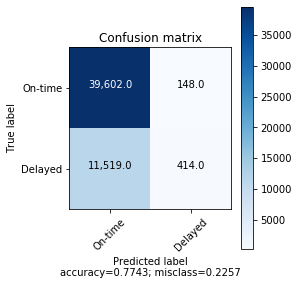

Summary Stats
Precision = 0.7366548042704626
Recall = 0.03469370652811531
F1 Score = 0.06626650660264106
Class 0 precision = 0.7746718569668043
Class 0 recall = 0.9962767295597484
Class 0 F1 Measure = 0.8716092042565835
Class 1 precision = 0.7366548042704626
Class 1 recall = 0.03469370652811531
Class 1 F1 Measure = 0.06626650660264106
Weighted recall = 0.7742584602287019
Weighted precision = 0.7658941643052821
Weighted F(1) Score = 0.6856649980165336
Weighted F(0.5) Score = 0.6572515154411019
Weighted false positive rate = 0.7432880241408383

In [0]:
from pyspark.ml import Pipeline, PipelineModel
pipelineModel = None

# E2E Pipeline
stages = createStages2(train_data, outcome, run)
gbt = GBTClassifier(maxIter = 20, maxDepth = 4, maxBins = 27 )
stages += [gbt]

pipeline = Pipeline(stages = stages)

#Transform and train the model
model = pipeline.fit(train_data)

#Evaluate model
predictions = predictAndEvaluate(dev_data.where('(month == 11 and day_of_month >= 22) or (month == 12) or (month == 1 and day_of_month <= 3)'),
                                 model)


Test Area Under ROC: 0.6725349929303156
Test Area Under PR: 0.3024882157434535
Accuracy = 0.844696 
Test Error = 0.155304 
Confusion matrix:
[[655791. 1187.]
 [120007. 3381.]]

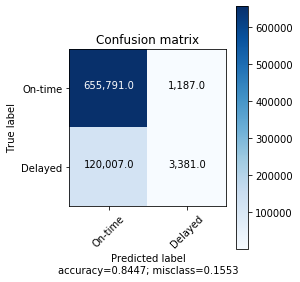

Summary Stats
Precision = 0.7401488616462347
Recall = 0.027401368042273156
F1 Score = 0.052846290912501176
Class 0 precision = 0.845311537281612
Class 0 recall = 0.9981932423916783
Class 0 F1 Measure = 0.9154131559992631
Class 1 precision = 0.7401488616462347
Class 1 recall = 0.027401368042273156
Class 1 F1 Measure = 0.052846290912501176
Weighted recall = 0.8446959503617533
Weighted precision = 0.8286836828885477
Weighted F(1) Score = 0.7790279209309421
Weighted F(0.5) Score = 0.7530113883863268
Weighted false positive rate = 0.8191013399278019

In [0]:
# Predict on full evaluation data
predictions = predictAndEvaluate(test_data.where('(month == 11 and day_of_month >= 22) or (month == 12) or (month == 1 and day_of_month <= 3)'), 
                                 model)